### 퀀트투자
    - 수학적, 통계적 기법을 활용해 투자 종목을 발굴하는 투자 방법
    - 이동평균선
        - 주식시장 파생상품시장에서 기술적 분석을 할 때 쓰이는 기본 도구
        - 거래액, 매매 대금, 생산량 등 다양한 예측에 사용
        - 현재와 미래의 예측을 연결하는 합리적 연결방법
        - 종류
            - 단순이평 (SMA)
            - 지수이평선 (EMA) 
            - 가중평균
* 지수이동평균
    1. SMA = $46.60, 금일 종가는 $46.75
    2. 승수 = 2 / (1 + n) = 2 / ( 1 + 14) = 0.133
    3. EMA 계산 = (금일 종가 x 승수) + (전일 EMA x (1 – 승수)
                EMA = (46.75 x 0.133) + (46.60 x 0.867)
                EMA = $46.63

* https://julialang.kr/?p=2599
* pandas ewm:
    - com : 질량중심 값으로 평활계수를 계산합니다. [ a = 1(1+com) ]
    - span : 계산 기간으로 평활계수를 계산합니다. [ a = 2/(span+1) ]
    - halflife : 반감기를 이용하여 평활계수를 계산합니다. [ a= e^(-ln(2) / halflife) ]
    - alpha : 평활계수를 직접 입력합니다. [ 0 < a ≤ 1 ]
    - min_periods : 계산을위한 최소 기간입니다.
    - adjust : 상대적 가중치의 불균형을 해소하기위해 조정계수로 나눌지의 여부입니다. 대체로 값이 많을수록 adjust를 하는것이 유리합니다.
    - ignore_na : 가중치를 계산할때 누락값을 무시할지 여부 입니다.

In [95]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [96]:
def seldata(cols=['sday','sclose'],where='where sday>"2022-04-01" order by sday asc'):
    fname='_db/nstock.db'
    with sqlite3.connect(fname) as conn:
        cur=conn.cursor()
        coltxt=','.join(cols)
        sql='select '+coltxt+' from stockdb '+where
        print(sql)
        res=cur.execute(sql).fetchall()
    return res

res=seldata()    
res[:5]

select sday,sclose from stockdb where sday>"2022-04-01" order by sday asc


[('2022-04-04', 117000),
 ('2022-04-05', 116500),
 ('2022-04-06', 113000),
 ('2022-04-07', 113500),
 ('2022-04-08', 112000)]

In [97]:
cols=['sday','sclose']
df = pd.DataFrame(res,columns=cols)
df.tail()

,sday,sclose
23,2022-05-06,107500
24,2022-05-09,107500
25,2022-05-10,110000
26,2022-05-11,110500
27,2022-05-12,110500


In [98]:
mdf=df.set_index('sday')
mdf.tail()

,sclose
sday,
2022-05-06,107500
2022-05-09,107500
2022-05-10,110000
2022-05-11,110500
2022-05-12,110500


<AxesSubplot:xlabel='sday'>

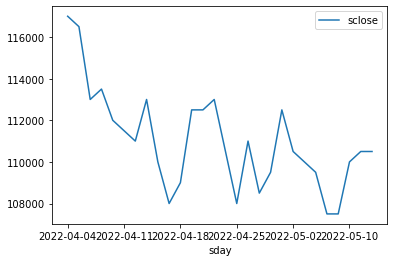

In [99]:
mdf.plot()

<AxesSubplot:xlabel='sday'>

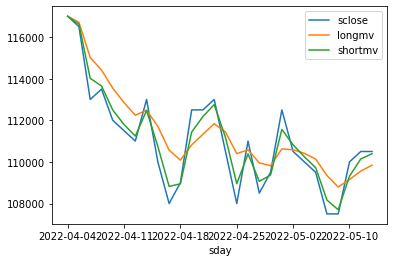

In [104]:
# alpha (평활계수) 를 직접제어 하여 투자 전략 구성

#mdf['ashortmv']=mdf['sclose'].ewm(alpha=0.3).mean()
mdf['longmv']=mdf['sclose'].ewm(alpha=0.3).mean()
mdf['shortmv']=mdf['sclose'].ewm(alpha=0.7).mean()
#mdf['elongmv']=mdf['sclose'].ewm(span=10).mean()
#mdf['shortstd']=mdf['sclose'].ewm().std()
#mdf['shortstd'].plot()
mdf[['sclose','longmv','shortmv']].plot()

### 이평선 투자 전략
- 골든크로스: 매수 타이밍
    * 단이평선이 장이평선을 뚫고 올라올때
    * 단기평균은 결국 장기평균의 상승을 리드한다.
- 데드크로스: 매도 타이밍
    * 단이평선이 장이평선을 뚫고 내려갈때
    * 단기평균이 장기평균의 하락을 리드한다.

In [111]:
def simStock(mdf):
    findex=mdf.iloc[:1,:].index[0]
    lindex=mdf.iloc[-1:,:].index[0]
    lindex
    invest=200000
    beforePos=-1
    beforeHold=0

    for i,row in mdf.iloc[10:,:].iterrows():
        if(row['shortmv']>=row['longmv']):
            nowpos=1 # short 상위
        else:
            nowpos=-1 # short 하위
        if beforePos==-1 and nowpos==1 and beforeHold==0:
            timing=1# 매수타이밍
            hold=1
            mdf.loc[i,'cash']=-row['sclose']
            mdf.loc[i,'hold']=1
        elif beforePos==1 and nowpos==-1 and beforeHold==1:
            timing=-1# 매수타이밍
            hold=0
            mdf.loc[i,'cash']=row['sclose']
            mdf.loc[i,'hold']=0
        else:
            mdf.loc[i,'cash']=0
            timing=0 # 홀드
            hold=beforeHold
            mdf.loc[i,'hold']=beforeHold
        beforeHold=hold
        beforePos=nowpos
        mdf.loc[findex,'cash']=invest
        mdf['cumcash']=mdf['cash'].cumsum()
        mdf['balance']=mdf['sclose']*mdf['hold']+mdf['cumcash']
    mdf.tail()
    ecash=mdf.loc[lindex,'balance']-invest
    erate=ecash/invest
    return(invest,ecash,erate)

In [112]:
simStock(mdf)

(200000, -4000.0, -0.02)

In [113]:
mdf.tail()

,sclose,sshortmv,shortmv,ashortmv,longmv,cash,hold,cumcash,balalce,balance
sday,,,,,,,,,,
2022-05-06,107500,110000.0,108167.093438,108167.093438,109345.858577,0.0,0.0,195500.0,195500.0,195500.0
2022-05-09,107500,109000.0,107700.128031,107700.128031,108792.026732,0.0,0.0,195500.0,195500.0,195500.0
2022-05-10,110000,108900.0,109310.038409,109310.038409,109154.452735,-110000.0,1.0,85500.0,195500.0,195500.0
2022-05-11,110500,109000.0,110143.011523,110143.011523,109558.143442,0.0,1.0,85500.0,196000.0,196000.0
2022-05-12,110500,109200.0,110392.903457,110392.903457,109840.713407,0.0,1.0,85500.0,196000.0,196000.0


<AxesSubplot:xlabel='sday'>

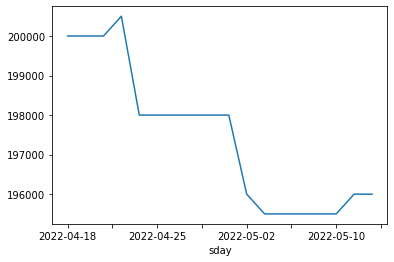

In [114]:
mdf['balance'].plot()